In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_scores(y_test, y_pred):
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    print('R2:  ', r2_score(y_test, y_pred))
    print('VAR:  ', np.var(y_test))

In [3]:
df = pd.read_csv('dataset11.csv')

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df = df.dropna().drop_duplicates(subset=df.columns.difference(['filename']))
df = df[(df.ncss > 20) & (df.ncss < 500) & (df.cyclo < 100) & (df.cyclo > 3) 
                       & (df.npath_method_avg < 100000.00)].copy().reset_index()
                       
df = df[~df["filename"].str.lower().str.contains("test")]
filename_with_index = df['filename']
df.drop('filename', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)
columns_patterns =  ONLY_PATTERNS
X = pd.DataFrame(df[ONLY_PATTERNS].values / df['ncss'].values.reshape((-1, 1)))
#X = pd.DataFrame(df[ONLY_PATTERNS].values)
y1 = df[['cyclo']].values[:, 0] #/ df['ncss'].values.reshape(-1)
y2 = df[['cyclo']].values[:, 0] / df['ncss'].values.reshape(-1)
X_train, X_test, y1_train, y1_test = train_test_split(X.values, y1, test_size=0.3, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(X.values, y2, test_size=0.3, random_state=42)
y3 = df[['Cognitive Complexity']].values[:, 0] #/ df['ncss'].values.reshape(-1)
y4 = df[['Cognitive Complexity']].values[:, 0] / df['ncss'].values.reshape(-1)
X_train, X_test, y3_train, y3_test = train_test_split(X.values, y3, test_size=0.3, random_state=42)
X_train, X_test, y4_train, y4_test = train_test_split(X.values, y4, test_size=0.3, random_state=42)

In [11]:
df.shape

(47400, 76)

# Experiments with our model(without grid search)
There are 4 situations:
1. target - cyclomatic complexity, target is not divided into ncss
2. target - cyclomatic complexity, target is divided into ncss
3. target - cognitive complexity, target is not divided into ncss
4. target - cognitive complexity, target is divided into ncss

# Two fold model(y = cyclo)

In [10]:
class TwoFoldRankingModel(BaseEstimator):
    importances = None
    model = None

    def __init__(self, tree_method='CatBoost'):
        if tree_method not in ['CatBoost', 'RF', 'LGBM']:
            raise "Unknown tree_method"
        self.tree_method = tree_method

    def fit(self, X, y):
        if self.tree_method == 'CatBoost':
            cat = CatBoostRegressor(verbose=0)
            cat.fit(X, y.ravel())
            self.model = cat
        elif self.tree_method == 'LGBM':
            lgbr = lgbm.LGBMRegressor(
                            learning_rate = 0.01, 
                            n_estimators = 1000
                            )
            lgbr.fit(X_train, y_train.ravel())
            self.model = lgbr
        elif self.tree_method == 'RF':
            rf_regr = RandomForestRegressor()
            rf_regr.fit(X_train, y_train)
            self.model = rf_regr
        
        self.importances = self.model.feature_importances_

    def predict(self, X, quantity_func='log'):   #  code snippet -- patterns representation
        patterns_number = self.importances.size
        ranked = []
        for snippet in X:
            if quantity_func == 'log':
                log_q = np.log(snippet + 1)
                pairs = np.vstack((log_q * self.importances,
                            np.arange(patterns_number))).T
            elif quantity_func == 'linear':
                pairs = np.vstack((snippet * self.importances,
                            np.arange(patterns_number))).T
            elif quantity_func == 'exp':
                exp_q = np.exp(snippet + 1)
                pairs = np.vstack((exp_q * self.importances,
                            np.arange(patterns_number))).T
            else:
                raise "Unknown func"
            pairs = pairs[pairs[:,0].argsort()]
            ranked.append(pairs[:,1].T.tolist()[::-1])

        return np.array(ranked)

    def recommend(self, snippet, display=False):
        log_q = np.log(snippet + 1)
        patterns_number = self.importances.size
        pairs = np.vstack((log_q * self.importances,
                           np.arange(patterns_number)))
        pairs = pairs.T.tolist()
        pairs.sort(reverse=True)
        pairs = list(map(lambda p: [p[0], int(p[1])], pairs))
        recommendation = ONLY_PATTERNS[pairs[0][1]]
        if display:
            print(recommendation)
        
        return recommendation


## Model1(cyclomatic complexity, not normalized on ncss target)

In [11]:
%%time 

twofold_model1 = TwoFoldRankingModel()
twofold_model1.fit(X_train, y1_train)

Wall time: 1min 3s


In [12]:
twofold_pred_log1 = twofold_model1.predict(X_test, 'log')
twofold_pred_lin1 = twofold_model1.predict(X_test, 'linear')

In [13]:
print_scores(y1_test, twofold_model1.model.predict(X_test))

MSE:  43.63017977018859
MAE:  3.859384452861997
MAPE: 22.75698119305808
R2:   0.8441953108412644
VAR:   280.0312365806762


## Model2(cyclomatic complexity, normalized on ncss target)

In [14]:
%%time 

twofold_model2 = TwoFoldRankingModel()
twofold_model2.fit(X_train, y2_train)

Wall time: 56.6 s


In [15]:
twofold_pred_log2 = twofold_model2.predict(X_test, 'log')
twofold_pred_lin2 = twofold_model2.predict(X_test, 'linear')

In [16]:
print_scores(y2_test, twofold_model2.model.predict(X_test))

MSE:  0.00612652900817042
MAE:  0.0550955864913704
MAPE: 19.38956324318368
R2:   0.39123122050810977
VAR:   0.010063802899491554


# Two fold model(y = cognitive)

## Model3(cognitive complexity, not normalized on ncss target)

In [17]:
%%time 

twofold_model3 = TwoFoldRankingModel()
twofold_model3.fit(X_train, y3_train)

Wall time: 54.2 s


In [18]:
twofold_pred_log3 = twofold_model3.predict(X_test, 'log')
twofold_pred_lin3 = twofold_model3.predict(X_test, 'linear')

In [19]:
print_scores(y3_test, twofold_model3.model.predict(X_test))

MSE:  130.73727877105534
MAE:  6.492057557452646


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.7080584136914372
VAR:   447.8199917461391


## Model3(cognitive complexity, normalized on ncss target)

In [22]:
%%time 

twofold_model4 = TwoFoldRankingModel()
twofold_model4.fit(X_train, y4_train)

Wall time: 54.6 s


In [23]:
twofold_pred_log4 = twofold_model4.predict(X_test, 'log')
twofold_pred_lin4 = twofold_model4.predict(X_test, 'linear')

In [24]:
print_scores(y4_test, twofold_model4.model.predict(X_test))

MSE:  0.020014426328825503
MAE:  0.09835986720957691


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.4528476085103216
VAR:   0.03657925404352923


# Comparison

The results of the quality estimation of 4 models are given below. In case of normalization MSE is noticeably lower, but R2-score is better when the target variable is not normalized on ncss. 

                            Table of results of comparison of quality of work of models with different targets

| Results | not norm cyclo | norm cyclo | not norm cognitive | norm cognitive | 
|--- | --- | --- | --- | --- |
| MSE | 43.63 | 0.006 |  130.737 | 0.02 |
| R2 | 0.844 | 0.391 | 0.708 | 0.453 |

You can see on the graphics below that the models with cyclomatic and cognitive complexity show similar results in assessing the importance of patterns. In case of normalized targets, the importances are more different. It is more logical to use the normalized values of the target variable.

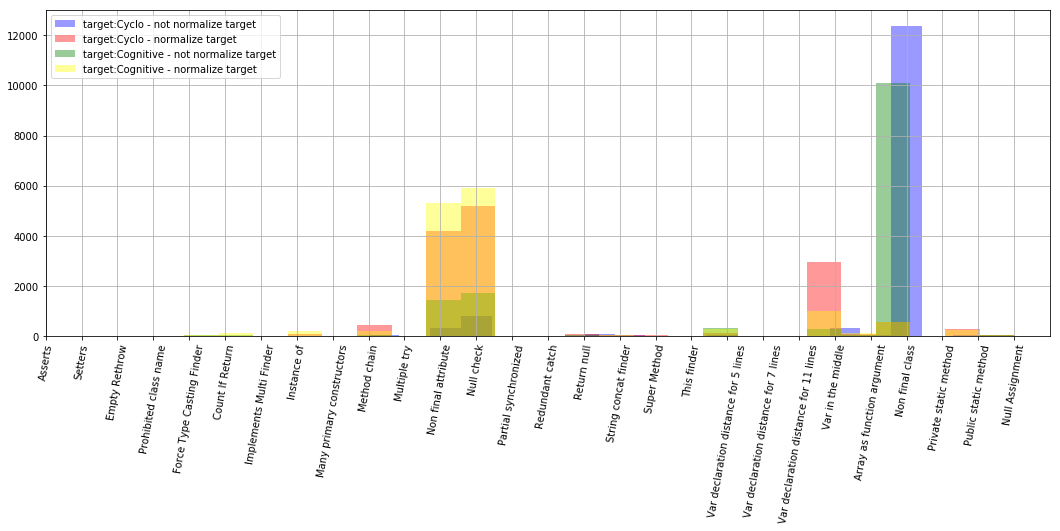

In [29]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='target:Cyclo - not normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
sns.distplot(twofold_pred_log2[:, 0], label='target:Cyclo - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='r')
sns.distplot(twofold_pred_log3[:, 0], label='target:Cognitive - not normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='green')
sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='yellow')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS, rotation=80)
plt.legend();

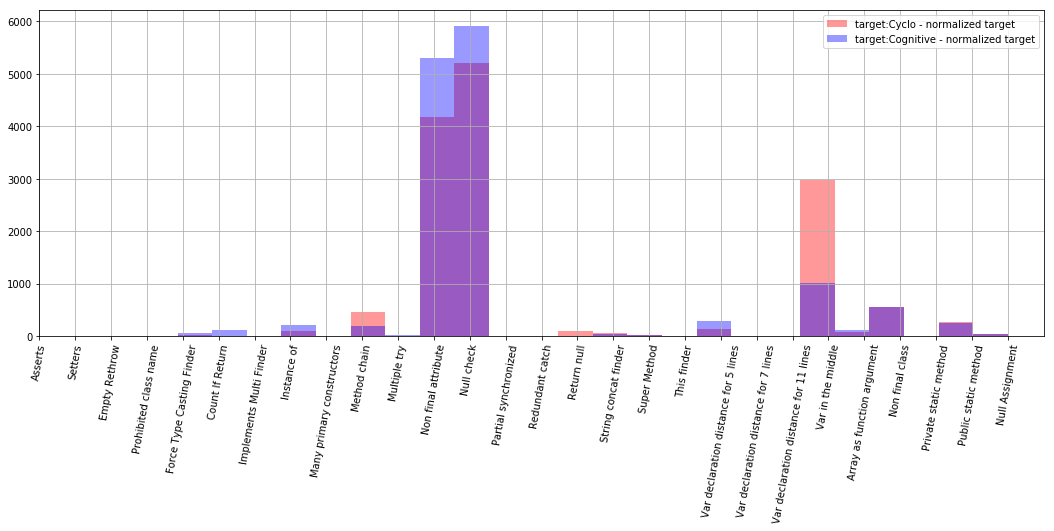

In [33]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log2[:, 0], label='target:Cyclo - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='r')
sns.distplot(twofold_pred_log4[:, 0], label='target:Cognitive - normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS, rotation=80)
plt.legend();

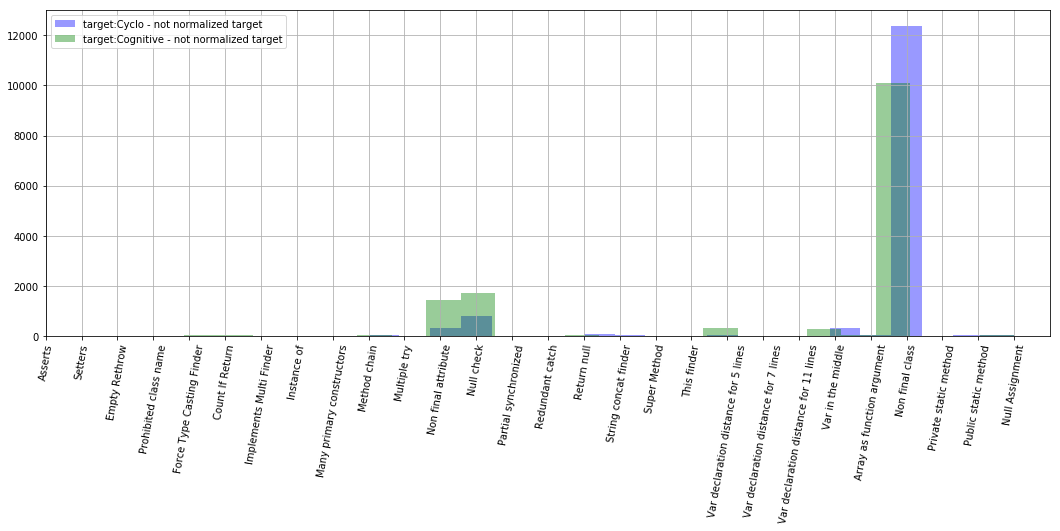

In [30]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log1[:, 0], label='target:Cyclo - not normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
sns.distplot(twofold_pred_log3[:, 0], label='target:Cognitive - not normalized target', bins = FEATURES_NUMBER, hist = True, kde=False, color='green')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS, rotation=80)
plt.legend();

-------------------------------------------------------

## Model from aibolit(additional research) - use grid seacrh

In [4]:
class TwoFoldRankingModel(BaseEstimator):

    def __init__(self):
        self.do_rename_columns = False
        self.model = None
        self.features_conf = None

    def fit(self, X, y, display=False):
        """
        Args:
            X: np.array with shape (number of snippets, number of patterns) or
                (number of patterns, ).
            y: np.array with shape (number of snippets,), array of snippets'
                complexity metric values
            display: bool, to output info about training or not
        """
        model = CatBoost()

        grid = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10],
                'l2_leaf_reg': [1, 3, 5, 7, 9]}

        model.grid_search(
            grid,
            X=X,
            y=y,
            verbose=display)

        self.model = model
        self.model.fit(X, y.ravel())

    def __get_pairs(self, item, th: float):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        pattern_importances = item * self.model.feature_importances_
        th_mask = (sigmoid(pattern_importances) > th) + 0
        pattern_importances = pattern_importances * th_mask
        order = np.arange(self.model.feature_importances_.size)
        return (pattern_importances, order)

    def __vstack_arrays(self, res):
        return np.vstack(res).T

    def predict(self, X, quantity_func='log', th=0.0):
        """
        Args:
            X: np.array with shape (number of snippets, number of patterns) or
                (number of patterns, ).
            quantity_func: str, type of function that will be applied to
                number of occurrences.
            th (float): Sensitivity of algorithm to recommend.
                0 - ignore all recomendations
                1 - use all recommendations
        Returns:
            ranked: np.array with shape (number of snippets, number of patterns)
                of sorted patterns in non-increasing order for each snippet of
                code.
        """

        if X.ndim == 1:
            X = X.copy()
            X = np.expand_dims(X, axis=0)

        ranked = []
        quantity_funcs = {
            'log': lambda x: np.log1p(x) / np.log(10),
            'exp': lambda x: np.exp(x + 1),
            'linear': lambda x: x,
        }

        for snippet in X:
            try:
                item = quantity_funcs[quantity_func](snippet)
                pairs = self.__vstack_arrays(self.__get_pairs(item, th))
                pairs = pairs[pairs[:, 0].argsort()]
                ranked.append(pairs[:, 1].T.tolist()[::-1])
            except Exception:
                raise Exception("Unknown func")

        return np.array(ranked)

# Model with cyclomatic complexity

In [1]:
#%%time 

#twofold_model = TwoFoldRankingModel()
#twofold_model.fit(X_train, y2_train)

In [16]:
twofold_pred_log = twofold_model.predict(X_test, 'log')
twofold_pred_lin = twofold_model.predict(X_test, 'linear')

In [18]:
print_scores(y2_test, twofold_model.model.predict(X_test))

MSE:  0.005779295846670161
MAE:  0.052122672479848885
MAPE: 17.98224584817051
R2:   0.42573439639183075
VAR:   0.010063802899491554


# Model with cognitive complexity

In [2]:
#%%time 

#twofold_model0 = TwoFoldRankingModel()
#twofold_model0.fit(X_train, y4_train)

In [21]:
twofold_pred_log0 = twofold_model0.predict(X_test, 'log')
twofold_pred_lin0 = twofold_model0.predict(X_test, 'linear')

In [22]:
print_scores(y4_test, twofold_model0.model.predict(X_test))

MSE:  0.01922877724904636
MAE:  0.09491268428435523


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


MAPE: inf
R2:   0.47432560472216956
VAR:   0.03657925404352923


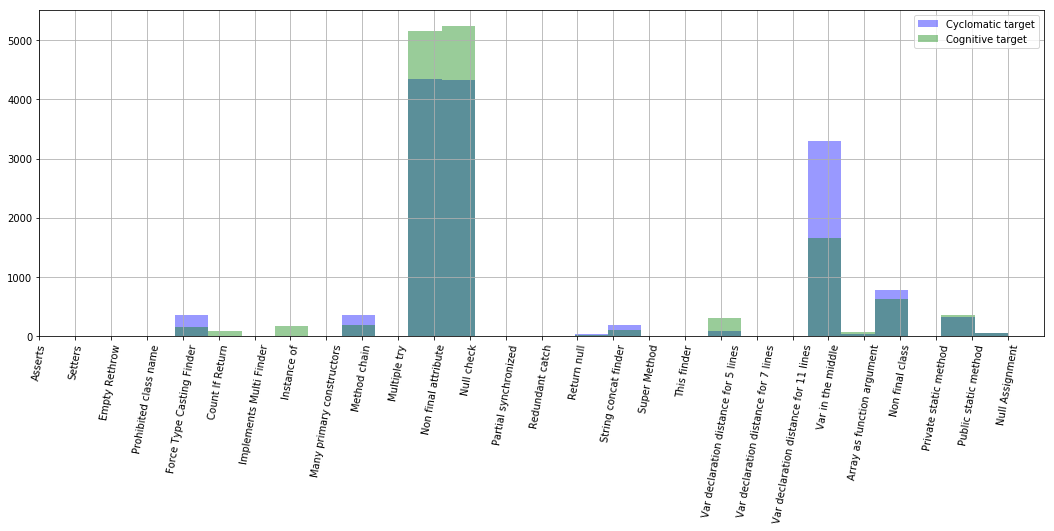

In [23]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log[:, 0], label='Cyclomatic target', bins = FEATURES_NUMBER, hist = True, kde=False, color='b')
sns.distplot(twofold_pred_log0[:, 0], label='Cognitive target', bins = FEATURES_NUMBER, hist = True, kde=False, color='green')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(0, FEATURES_NUMBER), labels=ONLY_PATTERNS, rotation=80)
plt.legend();

                       Table of results of comparison of quality of work of models with grid search and without it

| Results | norm cyclo(grid search) | norm cyclo | norm cognitive(grid search) | norm cognitive | 
|--- | --- | --- | --- | --- |
| MSE | 0.006 | 0.006 |  0.019 | 0.02 |
| R2 | 0.426 | 0.391 | 0.474 | 0.453 |

Results with grid search are better than without it. 

-----------------------------------------